In [1]:
%%capture

from siphon.catalog import TDSCatalog 
import numpy as np
import xarray as xr
import pandas as pd
import scipy
import gdal
from scipy.ndimage.filters import uniform_filter
from scipy import ndimage
from scipy.ndimage.filters import *
import os
import math
from osgeo import osr
from fractions import Fraction
import timeit
import matplotlib.pyplot as plt
#import matplotlib.image as mpimg
%matplotlib inline
import random
# import plotting tools
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib as mpl


In [2]:
location = (r'D:/PhD/junk')
os.chdir(location)
tc_2014 = 'D:/PhD/junk/ANUWALD.TreeCover.2014.250m.nc'
#url = 'http://dapds00.nci.org.au/thredds/dodsC/ub8/au/treecover/250m/ANUWALD.TreeCover.2014.250m.nc'
data = xr.open_dataset(tc_2014)
data

<xarray.Dataset>
Dimensions:    (latitude: 14000, longitude: 16800, time: 1)
Coordinates:
  * time       (time) datetime64[ns] 2014-12-31
  * latitude   (latitude) float32 -9.00125 -9.00375 ... -43.9963 -43.9987
  * longitude  (longitude) float32 112.001 112.004 112.006 ... 153.996 153.999
Data variables:
    TreeCover  (time, longitude, latitude) float32 ...
Attributes:
    creator_name:   Water and Landscape Dynamics group
    creator_url:    http://www.wenfo.org/wald/
    creator_email:  albert.vandijk@anu.edu.au
    institution:    Australian National University
    date_created:   19-Mar-2018
    ANU_license:    Creative Commons with Attribution (https://creativecommon...

In [3]:
list(data.variables.keys())

['TreeCover', 'time', 'latitude', 'longitude']

In [5]:
data.TreeCover

<xarray.DataArray 'TreeCover' (time: 1, longitude: 16800, latitude: 14000)>
[235200000 values with dtype=float32]
Coordinates:
  * time       (time) datetime64[ns] 2014-12-31
  * latitude   (latitude) float32 -9.00125 -9.00375 ... -43.9963 -43.9987
  * longitude  (longitude) float32 112.001 112.004 112.006 ... 153.996 153.999
Attributes:
    short_name:  TreeCover
    long_name:   Tree Cover
    units:       percent

In [4]:
trees = data.TreeCover.sel(time = '2014-12-31')
goodnight = trees.sel(latitude=slice(-25.15, -25.40), longitude=slice(151.80, 152.05))
study_site = goodnight.transpose('latitude', 'longitude')
study_site_n = np.array(study_site)


In [6]:
trees

<xarray.DataArray 'TreeCover' (longitude: 16800, latitude: 14000)>
[235200000 values with dtype=float32]
Coordinates:
    time       datetime64[ns] 2014-12-31
  * latitude   (latitude) float32 -9.00125 -9.00375 ... -43.9963 -43.9987
  * longitude  (longitude) float32 112.001 112.004 112.006 ... 153.996 153.999
Attributes:
    short_name:  TreeCover
    long_name:   Tree Cover
    units:       percent

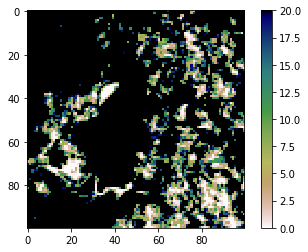

In [25]:
plt.imshow(study_site_n, cmap="gist_earth_r", vmax = 20)
plt.colorbar()

In [126]:
data.latitude

<xarray.DataArray 'latitude' (latitude: 14000)>
array([ -9.00125,  -9.00375,  -9.00625, ..., -43.99375, -43.99625, -43.99875],
      dtype=float32)
Coordinates:
  * latitude  (latitude) float32 -9.00125 -9.00375 -9.00625 -9.00875 ...
Attributes:
    long_name:  latitude
    units:      degrees_north

In [27]:
def array2raster(newRasterfn,rasterOrigin,pixelWidth,pixelHeight,array):

    cols = array.shape[1]
    rows = array.shape[0]
    originX = rasterOrigin[0]
    originY = rasterOrigin[1]

    driver = gdal.GetDriverByName('GTiff')
    outRaster = driver.Create(newRasterfn, cols, rows, 1, gdal.GDT_Byte)
    outRaster.SetGeoTransform((originX, pixelWidth, 0, originY, 0, pixelHeight))
    outband = outRaster.GetRasterBand(1)
    outband.WriteArray(array)
    outRasterSRS = osr.SpatialReference()
    outRasterSRS.ImportFromEPSG(4326)
    outRaster.SetProjection(outRasterSRS.ExportToWkt())
    outband.FlushCache()

def main(newRasterfn,rasterOrigin,pixelWidth,pixelHeight,array):
    reversed_arr = array[::-1] # reverse array so the tif looks like the array
    array2raster(newRasterfn,rasterOrigin,pixelWidth,pixelHeight,reversed_arr) # convert array to raster


if __name__ == "__main__":
    rasterOrigin = (151.80,-25.40)
    pixelWidth = 0.0025
    pixelHeight = 0.0025
    newRasterfn = 'new_test.tif'
    array = study_site_n
    main(newRasterfn,rasterOrigin,pixelWidth,pixelHeight,array)